In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

## Hyperparameters

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
lr = 0.0002
num_workers = 0
img_shape = (3, 32, 32)
g_input_dim = 100
num_epochs = 150
beta1 = 0.5
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## CIFAR-10 Datasets

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
train_data = torchvision.datasets.CIFAR10(root= "./data", train= True, download= True, transform= transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size, num_workers= num_workers)

Extracting ./data/cifar-10-python.tar.gz to ./data


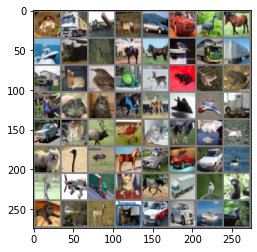

In [21]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.to("cpu").numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Define the model

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02).to(device)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02).to(device)
        nn.init.constant_(m.bias.data, 0).to(device)

### Generator

In [0]:
class Generator(nn.Module):
    def __init__(self, input_dim= 100):
        super(Generator, self).__init__()
        #self.input_dim = input_dim
        #self.fc1 = nn.Linear(self.input_dim, 2048)
        self.main = nn.Sequential(
            #nn.ConvTranspose2d(100, 512, kernel_size= (4, 4), stride= 2, padding= 1),    #100, 1, 1 --> 512, 2, 2
            #nn.BatchNorm2d(512),
            #nn.ReLU(True),

            nn.ConvTranspose2d(100, 256, kernel_size= (4, 4), stride= 1, padding= 0),    #512, 2, 2 --> 256, 4, 4
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size= (4, 4), stride= 2, padding=1),    #256x4x4 --> 128x8x8
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size= (4, 4), stride= 2, padding=1),    #128x8x8 --> 64x16x16
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size= (4, 4), stride= 2, padding=1),    #64x16x16 --> 3x32x32
            nn.BatchNorm2d(3),
            nn.Tanh()
        )

    def forward(self, z):
        #z = self.fc1(z)    #128 --> 2048
        #z = z.view((-1, 512, 2, 2))    #2048 --> (512, 2, 2)
        img = self.main(z)
        return img

### Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self, input_dim= (3, 32, 32)):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size= 4, stride= 2, padding= 1),    #3x32x32 --> 64x16x16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 128, kernel_size= 4, stride= 2, padding= 1),    #64x16x16 --> 128x8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, 256, kernel_size= 4, stride= 2, padding= 1),    #128x8x8 --> 256x4x4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),

            #nn.Conv2d(256, 512, kernel_size= 4, stride= 2, padding= 1),    #256x4x4 --> #512x2x2
            #nn.BatchNorm2d(512),
            #nn.LeakyReLU(0.2, True),

            nn.Conv2d(256, 1, kernel_size= 4, stride= 1, padding= 0),
            nn.Sigmoid(),
        )
    
    def forward(self, img):
        return self.main(img)

In [9]:
G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)

print(G)
print(D)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

## Define Loss and Optimizer

In [0]:
def real_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size).to(device)
    criterion = nn.BCELoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size).to(device) # fake labels = 0
    criterion = nn.BCELoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [0]:
d_optimizer = optim.Adam(D.parameters(), lr, betas=(beta1, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr, betas=(beta1, 0.999))

## Training

In [12]:
D.train().to(device)
G.train().to(device)
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        #TRAIN DISCRIMINATOR
        d_optimizer.zero_grad()

        #Train with real images
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)

        #Train with fake images
        z = np.random.uniform(-1, 1, size= (batch_size, g_input_dim, 1, 1))
        z = torch.from_numpy(z).float().to(device)
        fake_images = G(z)
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)

        #Combine loss
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        #TRAIN GENERATOR
        g_optimizer.zero_grad()

        z = np.random.uniform(-1, 1, size= (batch_size, g_input_dim, 1, 1))
        z = torch.from_numpy(z).float().to(device)
        fake_images = G(z)
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)

        g_loss.backward()
        g_optimizer.step()
    
    print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
        epoch+1, num_epochs, d_loss.item(), g_loss.item()))

Epoch [    1/  150] | d_loss: 0.3099 | g_loss: 3.1811
Epoch [    2/  150] | d_loss: 0.1338 | g_loss: 4.5165
Epoch [    3/  150] | d_loss: 0.4041 | g_loss: 4.0929
Epoch [    4/  150] | d_loss: 0.2446 | g_loss: 4.0351
Epoch [    5/  150] | d_loss: 0.4610 | g_loss: 1.4780
Epoch [    6/  150] | d_loss: 0.2771 | g_loss: 3.3264
Epoch [    7/  150] | d_loss: 1.1448 | g_loss: 0.4668
Epoch [    8/  150] | d_loss: 0.9917 | g_loss: 3.3255
Epoch [    9/  150] | d_loss: 1.2182 | g_loss: 1.7860
Epoch [   10/  150] | d_loss: 0.5422 | g_loss: 3.7815
Epoch [   11/  150] | d_loss: 0.3217 | g_loss: 1.8132
Epoch [   12/  150] | d_loss: 0.7137 | g_loss: 3.3835
Epoch [   13/  150] | d_loss: 0.3310 | g_loss: 2.5235
Epoch [   14/  150] | d_loss: 1.9261 | g_loss: 4.6772
Epoch [   15/  150] | d_loss: 0.3848 | g_loss: 3.8461
Epoch [   16/  150] | d_loss: 0.2776 | g_loss: 2.4633
Epoch [   17/  150] | d_loss: 0.4373 | g_loss: 3.8092
Epoch [   18/  150] | d_loss: 0.3008 | g_loss: 4.1412
Epoch [   19/  150] | d_loss

## Evaluation

In [0]:
def view_imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.to("cpu").detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

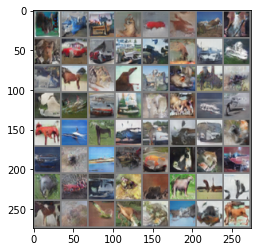

In [29]:
sample_size=64
rand_z = np.random.uniform(-1, 1, size=(sample_size, g_input_dim, 1, 1))
rand_z = torch.from_numpy(rand_z).float().to(device)

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)
view_imshow(torchvision.utils.make_grid(rand_images))